一个在目标检测任务中 重写 collate_fn 函数的实例

In [ ]:
dataloader = DataLoader(dataset,
                        batch_size=2,
                        collate_fn=collate_fn,
                        )


def collate_fn(batch):
    batch = list(zip(*batch))
    batch[0] = nested_tensor_from_tensor_list(batch[0])
    return tuple(batch)


def nested_tensor_from_tensor_list(tensor_list: List[Tensor]):
        max_size = max_by_axis([list(img.shape) for img in tensor_list])

        batch_shape = [len(tensor_list)] + max_size
        b, c, h, w = batch_shape
        dtype = tensor_list[0].dtype
        device = tensor_list[0].device
        tensor = torch.zeros(batch_shape, dtype=dtype, device=device)
        mask = torch.ones((b, h, w), dtype=torch.bool, device=device)
        for img, pad_img, m in zip(tensor_list, tensor, mask):
            pad_img[: img.shape[0], : img.shape[1], : img.shape[2]].copy_(img)
            m[: img.shape[1], :img.shape[2]] = False

    return NestedTensor(tensor, mask)


def max_by_axis(the_list):
    maxes = the_list[0]
    for sublist in the_list[1:]:
        for index, item in enumerate(sublist):
            maxes[index] = max(maxes[index], item)
    return maxes


class NestedTensor(object):
    def __init__(self, tensors, mask: Optional[Tensor]):
        self.tensors = tensors
        self.mask = mask

    def to(self, device):
        cast_tensor = self.tensors.to(device)
        mask = self.mask
        if mask is not None:
            assert mask is not None
            cast_mask = mask.to(device)
        else:
            cast_mask = None
        return NestedTensor(cast_tensor, cast_mask)

    def decompose(self):
        return self.tensors, self.mask

    def __repr__(self):
        return str(self.tensors)

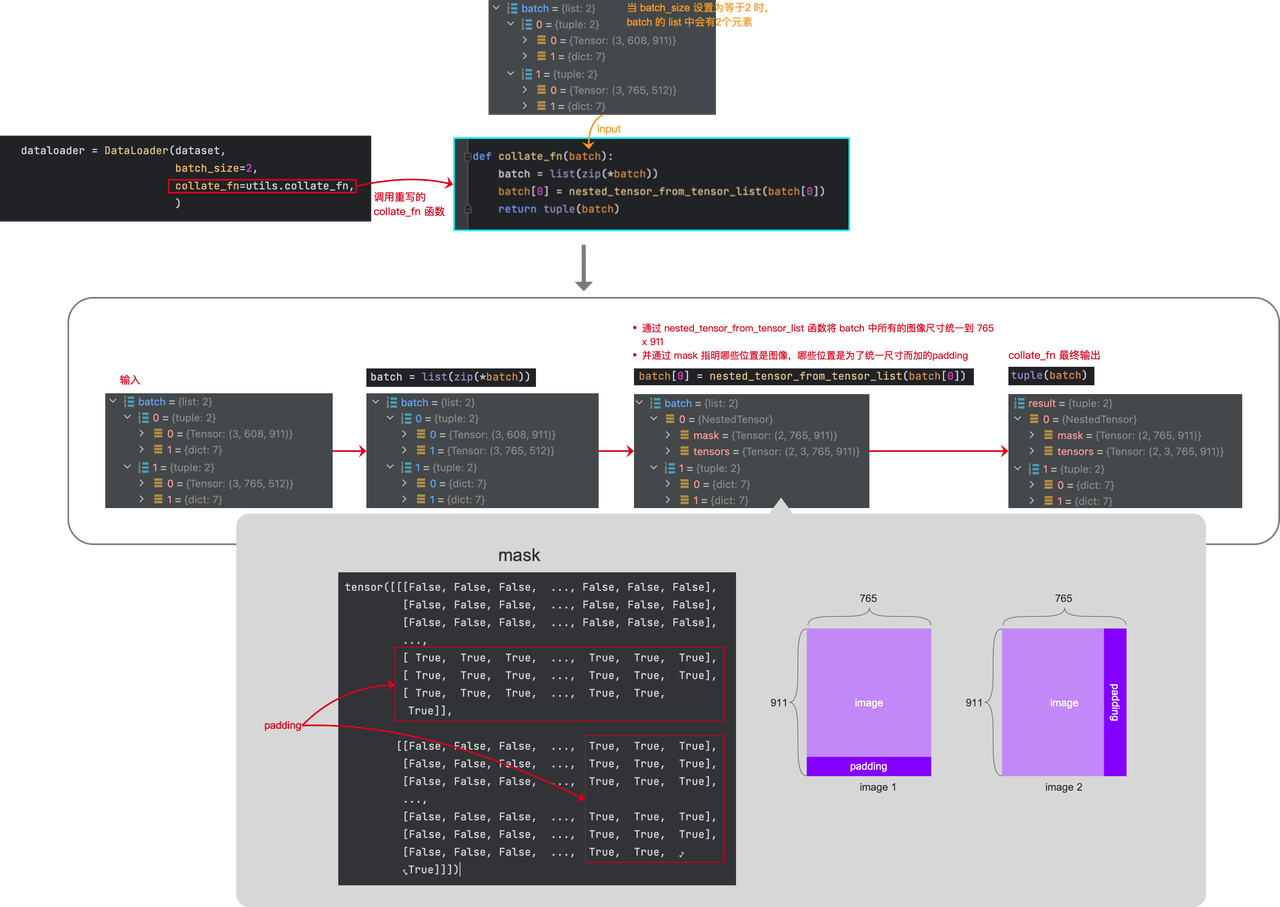